### 학습시킬 데이터 살펴보고 데이터 정제 및 이미리 처리(얼굴 찾아서 추출)하는 함수 생성

In [1]:
# GPU 사용 변수 설정
import torch

## mac m1 pro 환경
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # 윈도우 CUDA에서는 torch.device('cuda:3')

# MPS 지원 여부 확인
if torch.backends.mps.is_available():
    device = torch.device('mps')  # MPS 사용
elif torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA 사용
else:
    device = torch.device('cpu')  # CPU 사용

print(f"Using device: {device}")

Using device: mps


In [352]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 생성
import keras
from keras.utils import to_categorical

# 얼굴 디텍션
import cv2
from scipy.ndimage import zoom 

# 모델 생성
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# 데이터 확인
df = pd.read_csv("~/multimo/cam-emo/data/fer2013.csv")
df['Usage'].unique()  # ['Training', 'PublicTest', 'PrivateTest']
df  # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [7]:
# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [9]:
# train test 나누기
train_df = df[df['Usage']=='Training']
train_df
test_df = df[df['Usage']=='PublicTest']
test_df
# print(train_df.shape, test_df.shape)

,emotion,pixels,Usage
28709,0,"[254.0, 254.0, 254.0, 254.0, 254.0, 249.0, 255...",PublicTest
28710,1,"[156.0, 184.0, 198.0, 202.0, 204.0, 207.0, 210...",PublicTest
28711,4,"[69.0, 118.0, 61.0, 60.0, 96.0, 121.0, 103.0, ...",PublicTest
28712,6,"[205.0, 203.0, 236.0, 157.0, 83.0, 158.0, 120....",PublicTest
28713,3,"[87.0, 79.0, 74.0, 66.0, 74.0, 96.0, 77.0, 80....",PublicTest
...,...,...,...
32293,4,"[178.0, 176.0, 172.0, 173.0, 173.0, 174.0, 176...",PublicTest
32294,3,"[25.0, 34.0, 42.0, 44.0, 42.0, 47.0, 57.0, 59....",PublicTest
32295,4,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",PublicTest
32296,4,"[33.0, 25.0, 31.0, 36.0, 36.0, 42.0, 69.0, 103...",PublicTest


In [11]:
# 데이터를 활용하여 데이터셋 생성
shape_x = 48
shape_y = 48  # 48x48 pixel

# X_train, X_test, y_train, y_test split
X_train = train_df.iloc[ : , 1].values # train 픽셀값
X_test = test_df.iloc[ : , 1].values # test 픽셀값

y_train = train_df.iloc[ : , 0].values # train 표정값
y_test = test_df.iloc[ : ,  0 ].values # test 표정값

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# 전체데이터
X = df.iloc[ : , 1].values
y = df.iloc[ : , 0].values

# 배열구조 변경
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [23]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))

y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))
print(X_train_ds.shape, X_test_ds.shape, y_train_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (3589, 48, 48, 1) (28709, 1) (3589, 1)


In [360]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 데이터 스케일링
train_data /= 255  # 255로 나눈 것을 다시 자기 자신에 담음
test_data /= 255

# y 데이터(표정 번호) 원-핫 인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

In [45]:
# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1: ]  # (28709, 48, 48, 1)에서 뒤에 48, 48, 1만 가져오기
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


Text(0.5, 1.0, 'Ground truth: Happy')

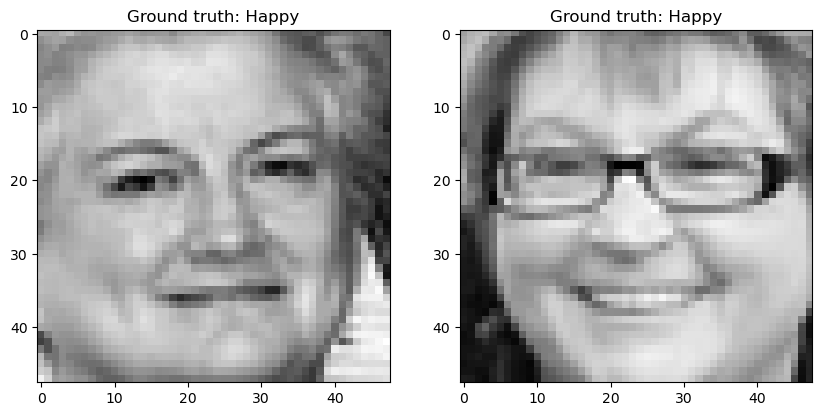

In [87]:
# 라벨 숫자를 문자로 변경
def get_label(x):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    return(labels.get(x, 'Invalid emotion'))

# 데이터 시각화
plt.figure(figsize=[10, 5])

# train 데이터 중 100번째 이미지
n=100

plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n, : , : ], axis=2), cmap='grey')
plt.title("Ground truth: {}".format(get_label(int(y_train[n]))))

# test 데이터 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n, : , : ], axis=2), cmap='grey')
plt.title("Ground truth: {}".format(get_label(int(y_test[n]))))

In [149]:
# openCV cascade를 활용해서 얼굴 객체 탐지
# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):
    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # RGB를 grayscale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6, minSize=(shape_x, shape_y), flags= cv2.CASCADE_SCALE_IMAGE)

    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])

    return gray, detected_faces, coord

In [159]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detect_faces, coord, offset_ceofficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:
        # 얼굴로 감지된 영역
        x, y, w, h = det

        # 이미지 경계값 받기
        horizontal_offset = int(np.floor(offset_ceofficients[0] * w))
        vertical_offset = int(np.floor(offset_ceofficients[1] * h))

        # 그레이스케일에서 해당 위치 가져오기
        extracted_face = gray[y + vertical_offset : y + h, x + horizontal_offset : x - horizontal_offset + w]

        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # scaled
        new_face.append(new_extracted_face)

    return new_face

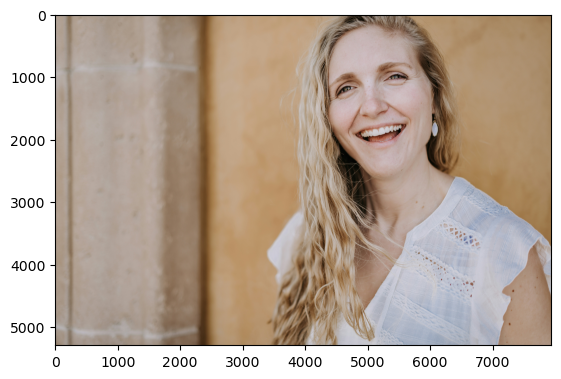

In [153]:
# 예시로 저장한 이미지 불러오기
samp1 = cv2.imread('/Users/dgriii0606/multimo/cam-emo/sampimg1.jpg')
plt.imshow(cv2.cvtColor(samp1, cv2.COLOR_BGR2RGB))

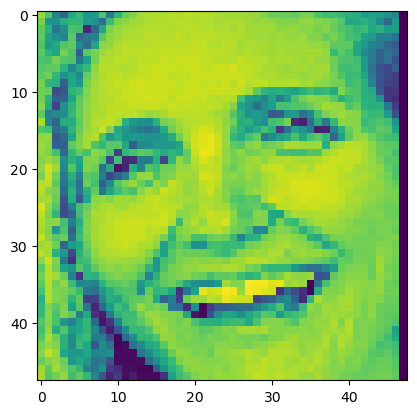

In [165]:
# 불러온 이미지의 얼굴 찾기
gray, detected_faces, coord = detect_face(samp1)

# 찾은 얼굴 추출하기
face_zoom = extract_face_features(gray, detected_faces, coord)

# 시각화
plt.imshow(face_zoom[0])

### 모델 생성 및 학습

In [256]:
def simple_model():
    model = Sequential()
    
    # 입력층 구성
    model.add(Input(shape=(48, 48, 1)))  # Input 객체를 사용하여 입력 정의 (권장)  # 위에 input_shape 값 입력 : (48, 48, 1)
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    
    # 은닉층 구성
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # flatten
    model.add(Flatten())
    
    # 완전연결계층 구성
    model.add(Dense(512, activation='relu'))
    
    # 출력층 구성
    model.add(Dense(7, activation='softmax'))
    
    return model

In [258]:
model = simple_model()
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,239 (2.55 MB)

 Trainable params: 667,239 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [402]:
# # 이미지 데이터 증강
# datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
#                              rotation_range=10,       # 램덤하게 이미지 회전하는 비율 (0도~180도)
#                              width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
#                              height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
#                              horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
#                              vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기
                             
# 모델 학습을 위한 파라미터 설정
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels_onehot, 
                    epochs = 30,  # 30에폭
                    batch_size = 100,
                    validation_data=(test_data, test_labels_onehot))

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.6240 - loss: 0.9894 - val_accuracy: 0.6116 - val_loss: 1.0242
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.6410 - loss: 0.9562 - val_accuracy: 0.6127 - val_loss: 1.0402
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.6514 - loss: 0.9159 - val_accuracy: 0.6286 - val_loss: 1.0156
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.6669 - loss: 0.8854 - val_accuracy: 0.6211 - val_loss: 1.0322
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.6811 - loss: 0.8516 - val_accuracy: 0.6007 - val_loss: 1.0562
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - accuracy: 0.6933 - loss: 0.8274 - val_accuracy: 0.6169 - val_loss: 1.0438
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.6999 - loss: 0.8052 - val_accuracy: 0.6130 - val_loss: 1.0473
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.7180 - loss: 0

In [406]:
# 이미지 데이터 증강
# 데이터 증강 설정
augmentation = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌
                                   rotation_range=10,       # 랜덤하게 이미지 회전
                                   width_shift_range=0.1,   # 랜덤하게 가로 이동
                                   height_shift_range=0.1,  # 랜덤하게 세로 이동
                                   horizontal_flip=True,    # 랜덤하게 수평 뒤집기
                                   vertical_flip=False)     # 수직 뒤집기 제외

# 증강된 데이터 생성
datagen = augmentation.flow(train_data, train_labels_onehot, batch_size=100)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(datagen,    # 증강된 데이터 사용
                    epochs=30,  # 30 에폭
                    validation_data=(test_data, test_labels_onehot))

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.5288 - loss: 1.3551 - val_accuracy: 0.6088 - val_loss: 1.0682
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.5677 - loss: 1.1471 - val_accuracy: 0.6049 - val_loss: 1.0624
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.5711 - loss: 1.1296 - val_accuracy: 0.6102 - val_loss: 1.0538
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.5758 - loss: 1.1177 - val_accuracy: 0.6194 - val_loss: 1.0243
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.5781 - loss: 1.1128 - val_accuracy: 0.6135 - val_loss: 1.0460
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.5816 - loss: 1.1068 - val_accuracy: 0.6183 - val_loss: 1.0403
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.5860 - loss: 1.0973 - val_accuracy: 0.6244 - val_loss: 1.0215
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.5903 - loss: 1.0893 - val

### 모델 평가 그래프 그리기

Text(0.5, 1.0, 'Accuracy Curves')

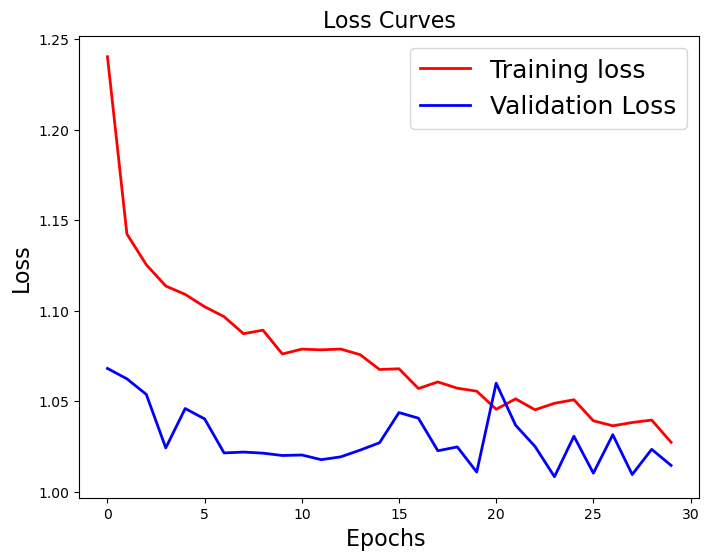

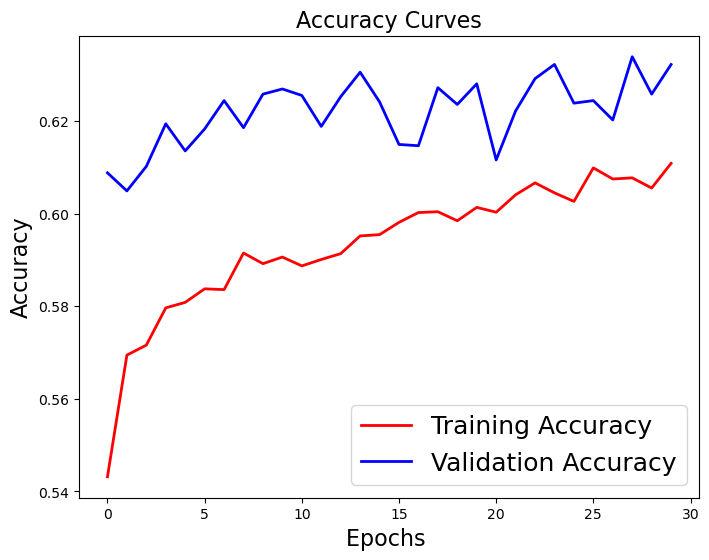

In [408]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### 샘플 이미지 불러와서 이미지 추론

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


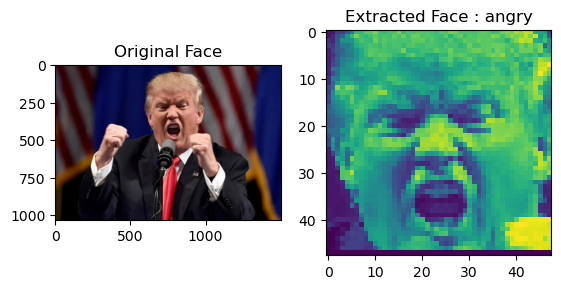

In [410]:
# 원본이미지 확인
face = cv2.imread('/Users/dgriii0606/multimo/cam-emo/trump5.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


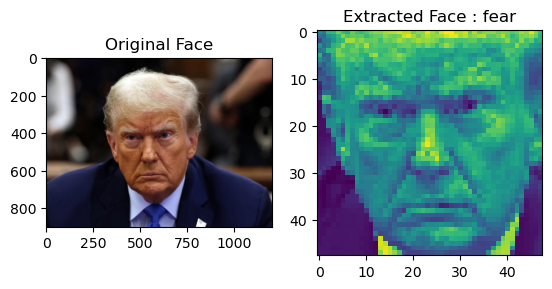

In [463]:
# 원본이미지 확인
face = cv2.imread('/Users/dgriii0606/multimo/cam-emo/trump4.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


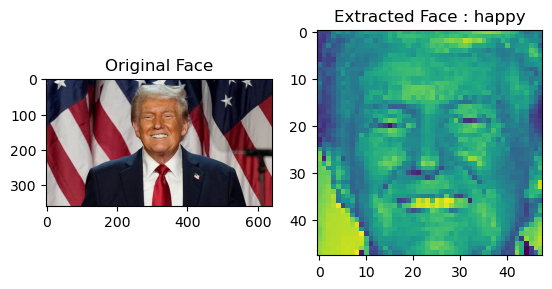

In [471]:
# 원본이미지 확인
face = cv2.imread('/Users/dgriii0606/multimo/cam-emo/trump1.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

### 위에서 학습한 모델 저장

In [480]:
# 모델 저장
model.save('/Users/dgriii0606/multimo/cam-emo/face_emotion.keras')